In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


144 ['../data/rubin_tiles_ecdfs/tile_x00000_y00000.npz', '../data/rubin_tiles_ecdfs/tile_x00000_y00256.npz', '../data/rubin_tiles_ecdfs/tile_x00000_y00512.npz']
['img', 'var', 'mask', 'wcs_hdr', 'x0', 'y0', 'tile_id', 'ra_center', 'dec_center', 'tile_size', 'stride', 'bands']


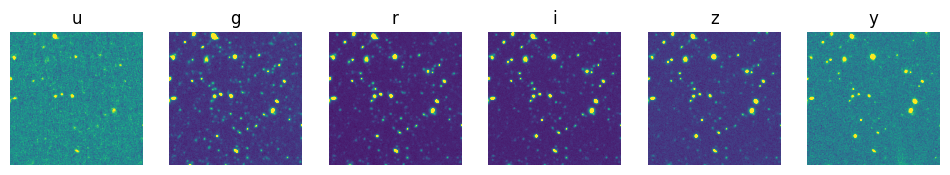

In [2]:
DATA_ROOT = os.path.expanduser("../data")
TILE_DIR  = os.path.join(DATA_ROOT, "rubin_tiles_ecdfs")

files = sorted(glob.glob(os.path.join(TILE_DIR, "*.npz")))
print(len(files), files[:3])

f = np.load(files[0])
print(f.files)
img  = f["img"]  
bands = ["u", "g", "r", "i","z","y"]

fig, axs = plt.subplots(1, img.shape[0], figsize=(12,4))
for i, ax in enumerate(axs):
    lo, hi = np.percentile(img[i], (1,99))
    ax.imshow(img[i], origin="lower", vmin=lo, vmax=hi)
    ax.set_title(bands[i])
    ax.axis("off")
plt.show()


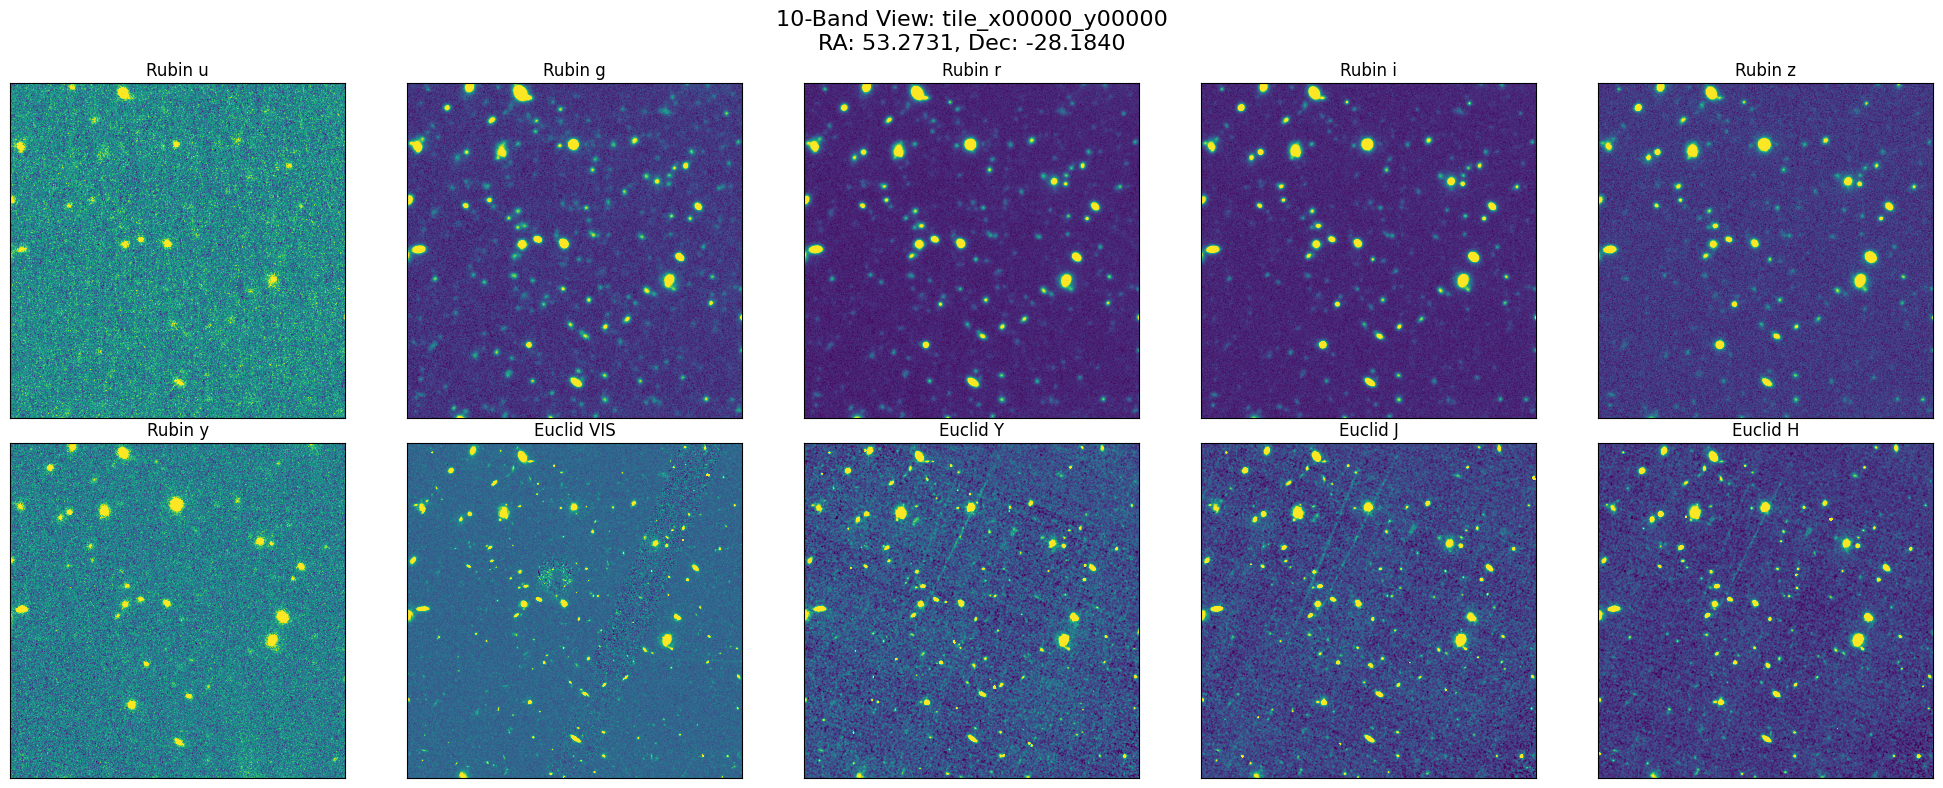

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
def robust_imshow(ax, img, title="", p=(1, 99)):
    if img is None:
        ax.set_title(f"{title} (missing)")
        ax.axis("off")
        return
    lo, hi = np.nanpercentile(img, p)
    ax.imshow(img, origin="lower", vmin=lo, vmax=hi)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
OUT_RUBIN_DIR = "../data/rubin_tiles_ecdfs"
OUT_EUCLID_DIR = "../data/euclid_tiles_ecdfs"

# ---- Path Configuration ----
tile_id_str = "tile_x00000_y00000"
rubin_path  = os.path.join(OUT_RUBIN_DIR,  f"{tile_id_str}.npz")
euclid_path = os.path.join(OUT_EUCLID_DIR, f"{tile_id_str}_euclid.npz")

# 1. Load Data
r_data = np.load(rubin_path)
e_data = np.load(euclid_path)

# Bands Mapping
# Rubin: u, g, r, i, z, y (indices 0-5)
# Euclid: VIS, Y, J, H
rubin_bands = ["u", "g", "r", "i", "z", "y"]
euclid_bands = ["VIS", "Y", "J", "H"]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# 2. Plot Rubin Bands (Top Row + 1st of Bottom)
for i, band in enumerate(rubin_bands):
    ax = axes[i]
    img = r_data['img'][i]
    robust_imshow(ax, img, title=f"Rubin {band}")

# 3. Plot Euclid Bands (Remaining 4 slots)
for i, band in enumerate(euclid_bands):
    ax = axes[i + 6] # Start at index 6
    img_key = f"img_{band}"
    
    if img_key in e_data:
        img = e_data[img_key]
        # We can also parse the WCS if needed:
        # wcs = WCS(e_data[f"wcs_{band}"]) 
        robust_imshow(ax, img, title=f"Euclid {band}")
    else:
        ax.set_title(f"Euclid {band} (Missing)")
        ax.axis('off')

plt.suptitle(f"10-Band View: {tile_id_str}\nRA: {r_data['ra_center']:.4f}, Dec: {r_data['dec_center']:.4f}", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
print(np.shape(img))

(1050, 1050)


Rubin keys: ['img', 'var', 'mask', 'wcs_hdr', 'x0', 'y0', 'tile_id', 'ra_center', 'dec_center', 'tile_size', 'stride', 'bands']
Euclid keys: ['ra_center', 'dec_center', 'tile_id', 'img_VIS', 'wcs_VIS', 'var_VIS', 'img_Y', 'wcs_Y', 'var_Y', 'img_J', 'wcs_J', 'var_J', 'img_H', 'wcs_H', 'var_H']


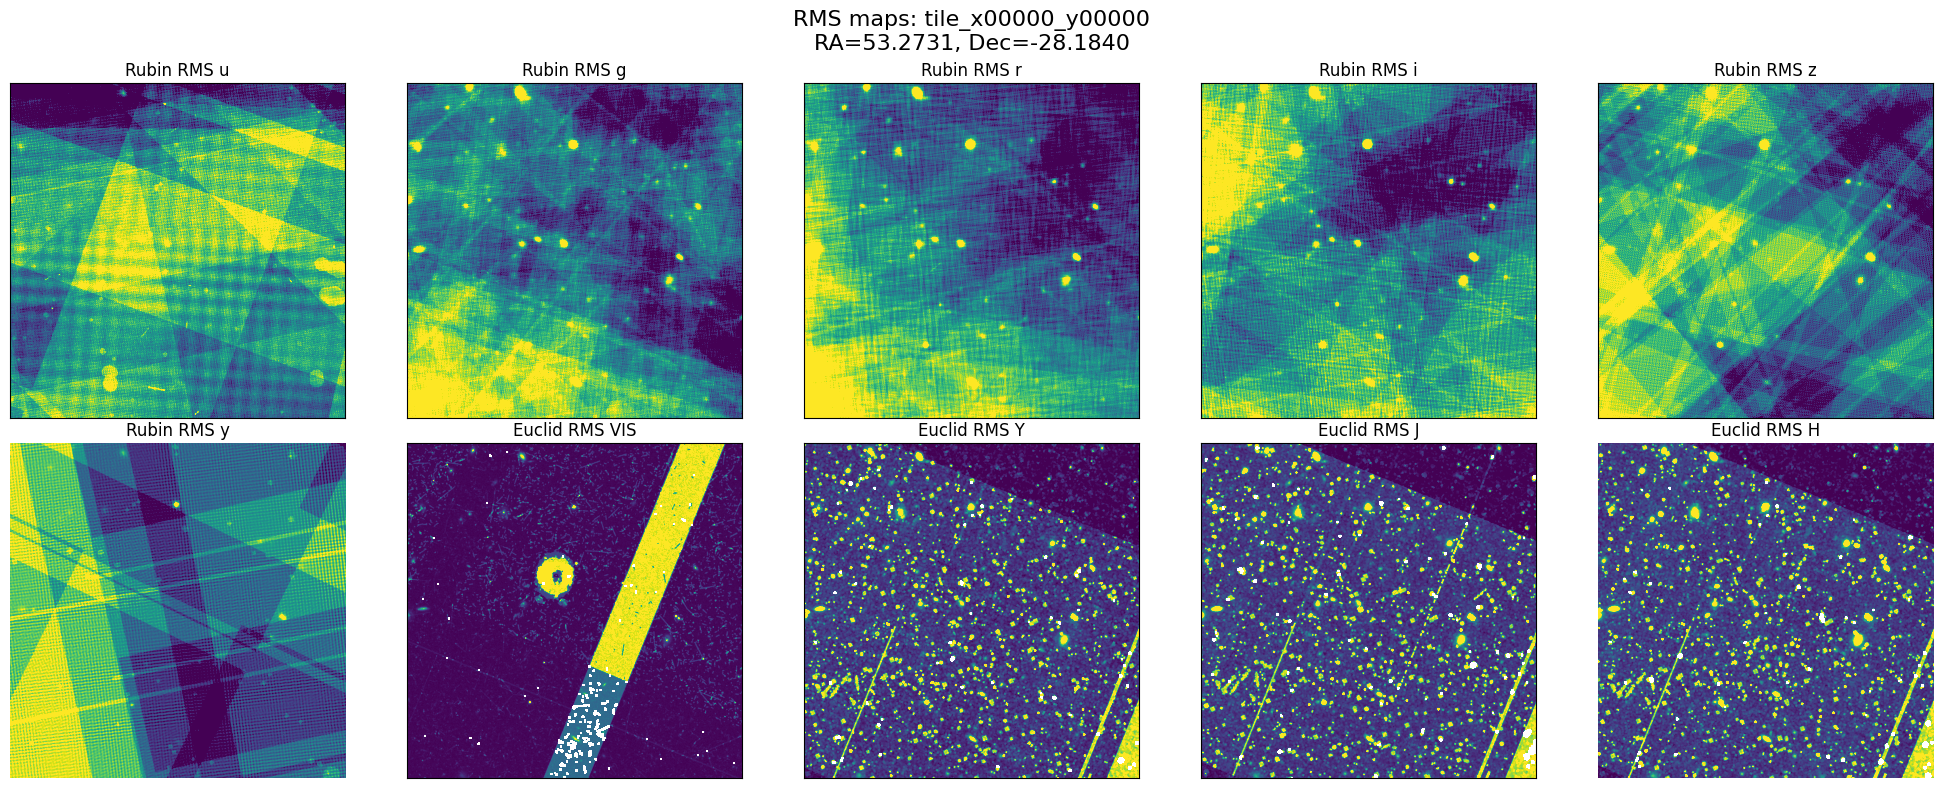

In [6]:
print("Rubin keys:", r_data.files)
print("Euclid keys:", e_data.files)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

# --- Rubin RMS ---
for i, band in enumerate(rubin_bands):
    ax = axes[i]
    if "var" in r_data:
        rms = np.sqrt(r_data["var"][i])
        robust_imshow(ax, rms, title=f"Rubin RMS {band}", p=(5, 95))
    else:
        ax.set_title(f"Rubin RMS {band} (missing)")
        ax.axis("off")

# empty slot
axes[5].axis("off")

# --- Euclid RMS ---
for i, band in enumerate(euclid_bands):
    ax = axes[i + 6]
    key = f"var_{band}"
    if key in e_data:
        rms = np.sqrt(e_data[key])
        robust_imshow(ax, rms, title=f"Euclid RMS {band}", p=(5, 95))
    else:
        ax.set_title(f"Euclid RMS {band} (missing)")
        ax.axis("off")

axes[9].axis("off")

plt.suptitle(
    f"RMS maps: {tile_id_str}\nRA={r_data['ra_center']:.4f}, Dec={r_data['dec_center']:.4f}",
    fontsize=16
)
plt.tight_layout()
plt.show()


# Torch dataset class

In [7]:

import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

RUBIN_BANDS  = ["u", "g", "r", "i", "z", "y"]
EUCLID_BANDS = ["VIS", "Y", "J", "H"]


def _to_float32(x):
    x = np.asarray(x)
    return x.astype(np.float32, copy=False) if x.dtype != np.float32 else x


def _safe_sqrt_var(var: np.ndarray) -> np.ndarray:
    """sqrt(max(var,0)) while preserving NaNs."""
    var = _to_float32(var)
    # keep NaNs; only clamp finite negatives to 0
    out = var.copy()
    m = np.isfinite(out)
    out[m] = np.maximum(out[m], 0.0)
    return np.sqrt(out, dtype=np.float32)


def _extract_wcs_like(npz_obj, band=None):
    """
    WCS is stored as strings (to_header_string) in your Euclid saver.
    Rubin may store a header-ish blob under various keys.
    We keep this loose and return whatever is present.
    """
    if band is None:
        for k in ("wcs_hdr", "wcs", "WCS", "header", "fits_header"):
            if k in npz_obj:
                return npz_obj[k]
        return None

    for k in (f"wcs_{band}", f"WCS_{band}", f"header_{band}", f"fits_header_{band}"):
        if k in npz_obj:
            return npz_obj[k]
    return None


def jaisp_collate_variable(batch):
    """
    Variable-size collate: keep images/var/rms as lists (no stacking across batch),
    because Rubin and Euclid have different shapes and tiles can vary.
    """
    out = {
        "x_rubin":    [b["x_rubin"] for b in batch],      # list of (6,Hr,Wr) tensors
        "x_euclid":   [b["x_euclid"] for b in batch],     # list of (4,He,We) tensors
        "mask_euclid": torch.stack([b["mask_euclid"] for b in batch], dim=0),  # (B,4)
        "meta":       [b["meta"] for b in batch],
    }

    # Always present in this implementation
    out["var_rubin"]  = [b["var_rubin"] for b in batch]   # list of (6,Hr,Wr)
    out["var_euclid"] = [b["var_euclid"] for b in batch]  # list of (4,He,We)

    out["rms_rubin"]  = [b["rms_rubin"] for b in batch]   # list of (6,Hr,Wr)
    out["rms_euclid"] = [b["rms_euclid"] for b in batch]  # list of (4,He,We)

    return out


class RubinEuclidTiles(Dataset):
    """
    EXACT-SIZE paired dataset (no crop/pad/resample, no augmentation).

    Rubin file:  <tile_id>.npz
      - img: (6,Hr,Wr)
      - var: (6,Hr,Wr)
      - ra_center, dec_center
      - optional: wcs_hdr (or similar)

    Euclid file: <tile_id>_euclid.npz
      - img_VIS/img_Y/img_J/img_H
      - var_VIS/var_Y/var_J/var_H
      - optional: wcs_VIS, etc.

    Notes on missing Euclid:
      - if a Euclid file exists but one band is missing, we fill placeholders with ref_shape.
      - if the whole Euclid file is missing, we fall back to Rubin shape as placeholders
        (debug convenience only). mask_euclid will be all zeros in that case.
    """

    def __init__(
        self,
        rubin_dir,
        euclid_dir,
        tile_ids=None,
        euclid_missing="zeros",        # missing SCI: "zeros" | "nan"
        euclid_missing_var="nan",      # missing VAR: "nan" | "ones" | "zeros"
        return_wcs=False,
        mmap=True,
    ):
        self.rubin_dir = rubin_dir
        self.euclid_dir = euclid_dir
        self.euclid_missing = euclid_missing
        self.euclid_missing_var = euclid_missing_var
        self.return_wcs = return_wcs
        self.mmap = mmap

        if tile_ids is None:
            rubin_files = sorted(glob.glob(os.path.join(rubin_dir, "tile_x*_y*.npz")))
            tile_ids = [os.path.splitext(os.path.basename(p))[0] for p in rubin_files]
        self.tile_ids = list(tile_ids)

        self.pairs = []
        for tid in self.tile_ids:
            rp = os.path.join(self.rubin_dir, f"{tid}.npz")
            ep = os.path.join(self.euclid_dir, f"{tid}_euclid.npz")
            if os.path.exists(rp):
                self.pairs.append((tid, rp, ep))

        if len(self.pairs) == 0:
            raise FileNotFoundError("No Rubin tiles found (tile_x*_y*.npz).")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        tile_id, rubin_path, euclid_path = self.pairs[idx]

        # ---- Rubin ----
        r = np.load(rubin_path, mmap_mode="r" if self.mmap else None, allow_pickle=True)
        rubin_img = _to_float32(r["img"])  # (6,Hr,Wr)

        ra = float(r["ra_center"]) if "ra_center" in r else np.nan
        dec = float(r["dec_center"]) if "dec_center" in r else np.nan

        rubin_var = _to_float32(r["var"]) if "var" in r else None
        if rubin_var is None:
            # This should not happen in your current schema, but keep it robust.
            rubin_var = np.full_like(rubin_img, np.nan, dtype=np.float32)

        rubin_rms = _safe_sqrt_var(rubin_var)

        # ---- Euclid ----
        mask_e = np.zeros((len(EUCLID_BANDS),), dtype=np.float32)

        e_img_stack, e_var_stack = [], []
        wcs_e = {}

        def fill_sci(shape):
            if self.euclid_missing == "nan":
                return np.full(shape, np.nan, np.float32)
            return np.zeros(shape, np.float32)

        def fill_var(shape):
            if self.euclid_missing_var == "zeros":
                return np.zeros(shape, np.float32)
            if self.euclid_missing_var == "ones":
                return np.ones(shape, np.float32)
            # default "nan": safest; downstream can mask by finite(var)
            return np.full(shape, np.nan, np.float32)

        if os.path.exists(euclid_path):
            e = np.load(euclid_path, mmap_mode="r" if self.mmap else None, allow_pickle=True)

            # reference shape for placeholders
            ref_shape = None
            for b in EUCLID_BANDS:
                k_img = f"img_{b}"
                if k_img in e:
                    ref_shape = e[k_img].shape
                    break
            if ref_shape is None:
                # fallback only
                ref_shape = rubin_img.shape[-2:]

            for j, b in enumerate(EUCLID_BANDS):
                k_img = f"img_{b}"
                if k_img in e:
                    img = _to_float32(e[k_img])
                    mask_e[j] = 1.0
                else:
                    img = fill_sci(ref_shape)
                e_img_stack.append(img)

                k_var = f"var_{b}"
                if k_var in e:
                    v = _to_float32(e[k_var])
                else:
                    v = fill_var(ref_shape)
                e_var_stack.append(v)

                if self.return_wcs:
                    w = _extract_wcs_like(e, band=b)
                    if w is not None:
                        wcs_e[b] = w

        else:
            # No Euclid file at all: placeholders (debug convenience only)
            ref_shape = rubin_img.shape[-2:]
            for _ in EUCLID_BANDS:
                e_img_stack.append(fill_sci(ref_shape))
                e_var_stack.append(fill_var(ref_shape))

        euclid_img = np.stack(e_img_stack, axis=0)   # (4,He,We)
        euclid_var = np.stack(e_var_stack, axis=0)   # (4,He,We)
        euclid_rms = _safe_sqrt_var(euclid_var)      # (4,He,We)

        sample = {
            "x_rubin": torch.from_numpy(rubin_img),
            "x_euclid": torch.from_numpy(euclid_img),
            "var_rubin": torch.from_numpy(rubin_var),
            "var_euclid": torch.from_numpy(euclid_var),
            "rms_rubin": torch.from_numpy(rubin_rms),
            "rms_euclid": torch.from_numpy(euclid_rms),
            "mask_euclid": torch.from_numpy(mask_e),
            "meta": {
                "tile_id": tile_id,
                "ra_center": ra,
                "dec_center": dec,
                "rubin_path": rubin_path,
                "euclid_path": euclid_path,
                "rubin_bands": RUBIN_BANDS,
                "euclid_bands": EUCLID_BANDS,
                "rubin_hw": tuple(map(int, rubin_img.shape[-2:])),
                "euclid_hw": tuple(map(int, euclid_img.shape[-2:])),
            },
        }

        if self.return_wcs:
            sample["meta"]["wcs_rubin"] = _extract_wcs_like(r, band=None)
            sample["meta"]["wcs_euclid"] = wcs_e if len(wcs_e) else None

        return sample


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)


def make_loader(
    rubin_dir,
    euclid_dir,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    **dataset_kwargs,
):
    ds = RubinEuclidTiles(rubin_dir, euclid_dir, **dataset_kwargs)
    dl = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent_workers and (num_workers > 0),
        worker_init_fn=seed_worker if num_workers > 0 else None,
        drop_last=False,
        collate_fn=jaisp_collate_variable,
    )
    return ds, dl


In [8]:
ds, dl = make_loader(
    OUT_RUBIN_DIR, OUT_EUCLID_DIR,
    batch_size=1,
    num_workers=0,         # debug first
    return_wcs=True,
)

b = next(iter(dl))
print(len(b["x_rubin"]), b["x_rubin"][0].shape)
print(len(b["x_euclid"]), b["x_euclid"][0].shape)
print(b["meta"][0]["rubin_hw"], b["meta"][0]["euclid_hw"])

print("Rubin VAR:", b["var_rubin"][0].shape, torch.isfinite(b["var_rubin"][0]).any())
print("Euclid VAR:", b["var_euclid"][0].shape, torch.isfinite(b["var_euclid"][0]).any())

print("Rubin RMS:", b["rms_rubin"][0].shape)
print("Euclid RMS:", b["rms_euclid"][0].shape)

print("Euclid mask:", b["mask_euclid"][0])


1 torch.Size([6, 512, 512])
1 torch.Size([4, 1050, 1050])
[512, 512] [1050, 1050]
Rubin VAR: torch.Size([6, 512, 512]) tensor(True)
Euclid VAR: torch.Size([4, 1050, 1050]) tensor(True)
Rubin RMS: torch.Size([6, 512, 512])
Euclid RMS: torch.Size([4, 1050, 1050])
Euclid mask: tensor([1., 1., 1., 1.])


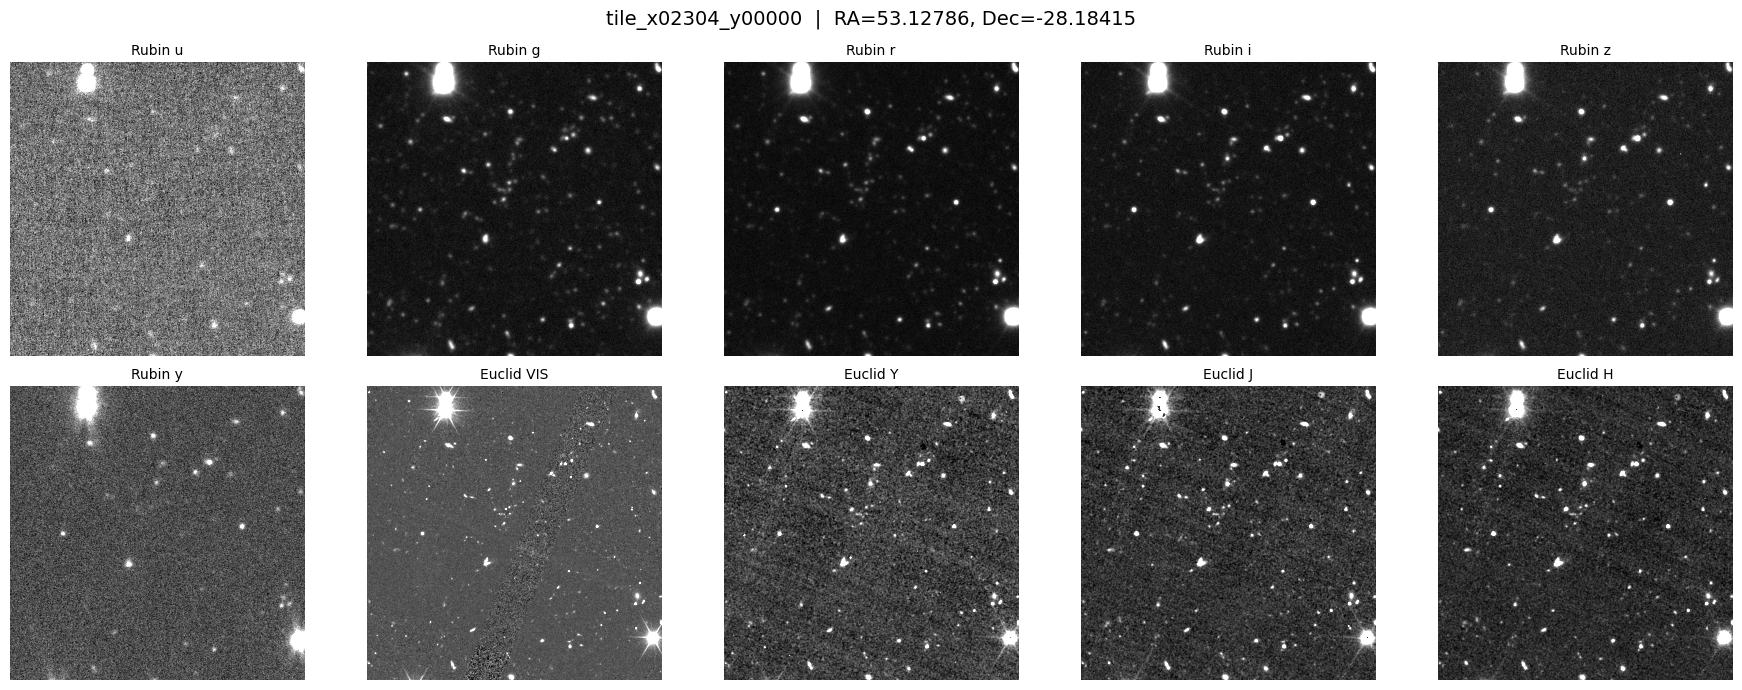

In [10]:
import random
batch = next(iter(dl))
i = random.randrange(len(batch["x_rubin"]))  # pick one sample in batch

def show(ax, img, title=None, qlo=1, qhi=99):
    vmin, vmax = np.percentile(img, (qlo, qhi))
    ax.imshow(img, origin="lower", cmap="gray", vmin=vmin, vmax=vmax)
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=10)

rubin = batch["x_rubin"][i].numpy()    # (6, Hr, Wr)
euclid = batch["x_euclid"][i].numpy()  # (4, He, We)
meta   = batch["meta"][i]

fig, axes = plt.subplots(2, 5, figsize=(18, 7))
axes = axes.ravel()

# --- Rubin (top row) ---
for b, band in enumerate(meta["rubin_bands"]):
    show(
        axes[b],
        rubin[b],
        title=f"Rubin {band}"
    )

# empty slot (top-right)
axes[5].axis("off")

# --- Euclid (bottom row) ---
for b, band in enumerate(meta["euclid_bands"]):
    show(
        axes[6 + b],
        euclid[b],
        title=f"Euclid {band}"
    )

# empty slot (bottom-right)
axes[9].axis("off")

fig.suptitle(
    f"{meta['tile_id']}  |  RA={meta['ra_center']:.5f}, Dec={meta['dec_center']:.5f}",
    fontsize=14
)

plt.tight_layout()
plt.show()


In [11]:
b = next(iter(dl))
print("batch keys:", b.keys())

i = 0

print("Rubin RMS object:", batch["rms_rubin"][i])
print("Euclid RMS shape:", batch["rms_euclid"][i].shape)


batch keys: dict_keys(['x_rubin', 'x_euclid', 'mask_euclid', 'meta', 'var_rubin', 'var_euclid', 'rms_rubin', 'rms_euclid'])
Rubin RMS object: tensor([[[ 6.1167,  6.1852,  6.1385,  ...,  5.4887,  5.7094,  5.7111],
         [ 6.0385,  6.1700,  6.1515,  ...,  5.5324,  5.6754,  5.6970],
         [ 6.1186,  6.1430,  6.2434,  ...,  5.5032,  5.5775,  5.7566],
         ...,
         [ 5.8439,  5.9086,  5.8546,  ...,  5.8347,  5.8284,  5.7128],
         [ 5.8386,  5.8182,  5.8747,  ...,  5.7984,  5.8810,  5.7051],
         [ 5.9368,  5.9833,  5.9478,  ...,  5.7942,  5.8175,  5.6486]],

        [[ 0.9735,  0.9705,  0.9733,  ...,  0.9567,  0.9527,  0.9515],
         [ 0.9848,  0.9825,  0.9854,  ...,  0.9562,  0.9525,  0.9580],
         [ 0.9811,  0.9783,  0.9788,  ...,  0.9510,  0.9504,  0.9531],
         ...,
         [ 0.9298,  0.9363,  0.9308,  ...,  0.9402,  0.9454,  0.9442],
         [ 0.9387,  0.9370,  0.9366,  ...,  0.9364,  0.9363,  0.9492],
         [ 0.9377,  0.9335,  0.9366,  ...,  0.9

Text(0.5, 0.98, 'RMS  |  tile_x02304_y00000')

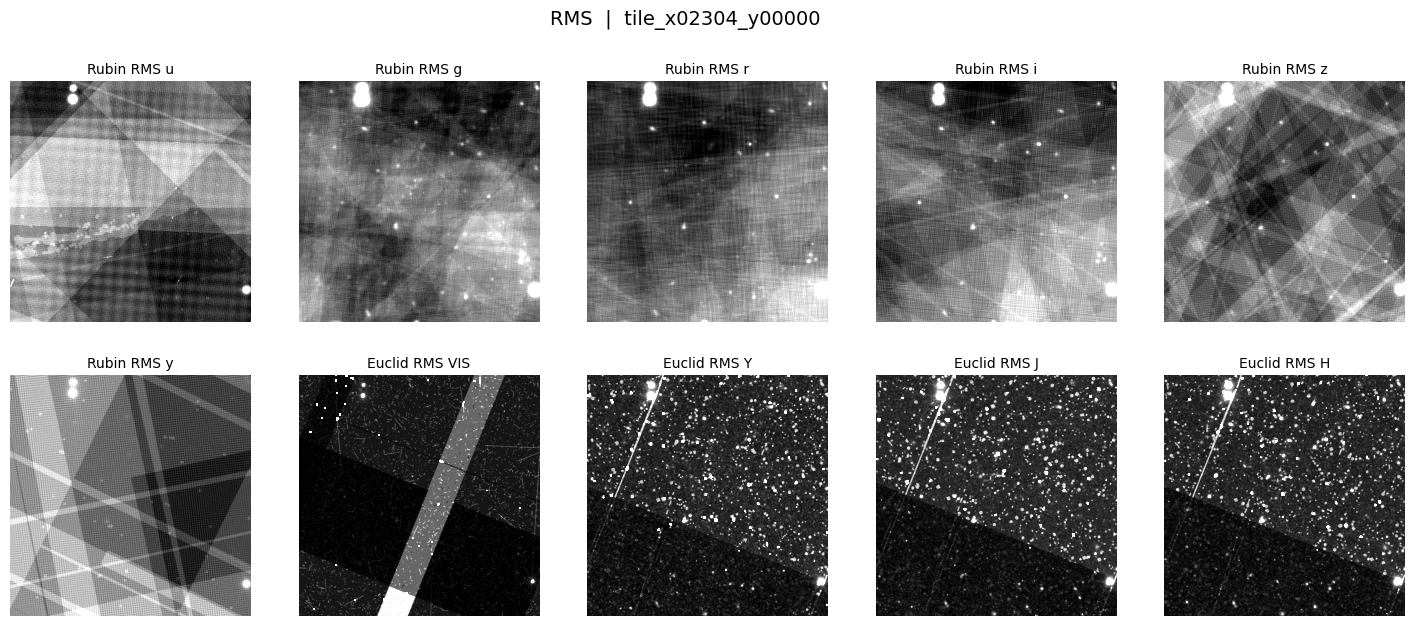

In [12]:
def show(ax, img, title=None, qlo=1, qhi=99):
    # handle missing
    if img is None:
        ax.text(0.5, 0.5, "missing", ha="center", va="center", fontsize=10)
        ax.axis("off")
        if title:
            ax.set_title(title, fontsize=10)
        return

    img = np.asarray(img)
    finite = np.isfinite(img)
    if finite.sum() == 0:
        ax.text(0.5, 0.5, "all-NaN", ha="center", va="center", fontsize=10)
        ax.axis("off")
        if title:
            ax.set_title(title, fontsize=10)
        return

    vmin, vmax = np.percentile(img[finite], (qlo, qhi))
    ax.imshow(img, origin="lower", cmap="gray", vmin=vmin, vmax=vmax)
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=10)

# RMS (may be missing for Rubin)
rubin_rms = None
if "rms_rubin" in batch and batch["rms_rubin"][i] is not None:
    rubin_rms = batch["rms_rubin"][i].numpy()

euclid_rms = batch["rms_euclid"][i].numpy()


# =======================
# RMS IMAGES
# =======================
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
axes = axes.ravel()

for b, band in enumerate(meta["rubin_bands"]):
    if rubin_rms is not None:
        show(axes[b], rubin_rms[b], title=f"Rubin RMS {band}")
    else:
        show(axes[b], None, title=f"Rubin RMS {band}")

axes[5].axis("off")

for b, band in enumerate(meta["euclid_bands"]):
    show(axes[6 + b], euclid_rms[b], title=f"Euclid RMS {band}")

axes[9].axis("off")

fig.suptitle(
    f"RMS  |  {meta['tile_id']}",
    fontsize=14
)


# Older (3 bands): 

In [ ]:
class RubinTileDataset(Dataset):
    def __init__(self, tile_dir):
        self.files = sorted(glob.glob(os.path.join(tile_dir, "*.npz")))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = np.load(self.files[idx])
        img = torch.from_numpy(f["img"]).float()   # [B,H,W]
        var = torch.from_numpy(f["var"]).float()
        msk = torch.from_numpy(f["mask"]).long()
        return img, var, msk

ds = RubinTileDataset(TILE_DIR)
dl = DataLoader(ds, batch_size=2, shuffle=True, num_workers=2)

img, var, msk = next(iter(dl))
img.shape, var.shape, msk.shape


In [ ]:
class TinyConv(nn.Module):
    def __init__(self, in_ch=3, out_ch=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, out_ch, 3, padding=1),
        )

    def forward(self, x):
        return self.net(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyConv().to(device)

img = img.to(device)
var = var.to(device)

out = model(img)
loss = (out**2).mean()   # dummy loss

loss.backward()
loss.item()

